<a href="https://colab.research.google.com/github/PacktPublishing/Modern-Computer-Vision-with-PyTorch-2E/blob/main/Chapter04/CNN_working_details.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%%capture
%pip install torch_summary

In [4]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torch.optim import SGD, Adam
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Matplotlib is building the font cache; this may take a moment.


In [5]:
X_train = (
    torch.tensor(
        [
            [[[1, 2, 3, 4], [2, 3, 4, 5], [5, 6, 7, 8], [1, 3, 4, 5]]],
            [[[-1, 2, 3, -4], [2, -3, 4, 5], [-5, 6, -7, 8], [-1, -3, -4, -5]]],
        ]
    )
    .to(device)
    .float()
)
X_train /= 8
y_train = torch.tensor([0, 1]).to(device).float()

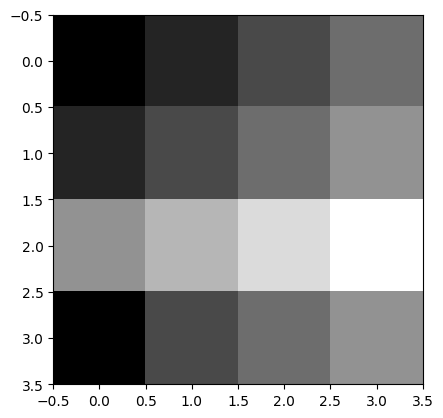

In [14]:
plt.imshow(X_train[0].permute(1, 2, 0), cmap='gray')

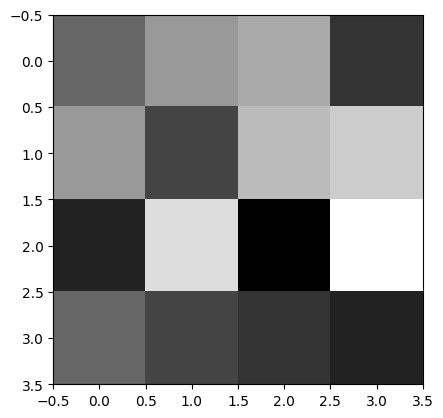

In [13]:
plt.imshow(X_train[1].permute(1, 2, 0), cmap='gray')

In [ ]:
def get_model():
    model = nn.Sequential(
        nn.Conv2d(1, 1, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(1, 1),
        nn.Sigmoid(),
    ).to(device)
    loss_fn = nn.BCELoss()
    optimizer = Adam(model.parameters(), lr=1e-2)
    return model, loss_fn, optimizer

In [ ]:
from torchsummary import summary
model, loss_fn, optimizer = get_model()
summary(model, X_train);

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 1, 2, 2]             10
├─MaxPool2d: 1-2                         [-1, 1, 1, 1]             --
├─ReLU: 1-3                              [-1, 1, 1, 1]             --
├─Flatten: 1-4                           [-1, 1]                   --
├─Linear: 1-5                            [-1, 1]                   2
├─Sigmoid: 1-6                           [-1, 1]                   --
Total params: 12
Trainable params: 12
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00


In [ ]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction.view(-1), y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [ ]:
trn_dl = DataLoader(TensorDataset(X_train, y_train))

In [ ]:
for epoch in range(2000):
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


In [ ]:
model(X_train[:1])

tensor([[0.0042]], grad_fn=<SigmoidBackward>)

In [ ]:
list(model.children())

[Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1)),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 ReLU(),
 Flatten(),
 Linear(in_features=1, out_features=1, bias=True),
 Sigmoid()]

In [ ]:
(cnn_w, cnn_b), (lin_w, lin_b) = [(layer.weight.data, layer.bias.data) for layer in list(model.children()) if hasattr(layer, 'weight')]

In [ ]:
h_im, w_im = X_train.shape[2:]
h_conv, w_conv = cnn_w.shape[2:]
sumprod = torch.zeros((h_im - h_conv + 1, w_im - w_conv + 1))

In [ ]:
for i in range(h_im - h_conv + 1):
    for j in range(w_im - w_conv + 1):
        img_subset = X_train[0, 0, i:(i+3), j:(j+3)]
        model_filter = cnn_w.reshape(3,3)
        val = torch.sum(img_subset*model_filter) + cnn_b
        sumprod[i,j] = val

In [ ]:
sumprod.clamp_min_(0)

tensor([[0., 0.],
        [0., 0.]])

In [ ]:
pooling_layer_output = torch.max(sumprod)

In [ ]:
intermediate_output_value = pooling_layer_output * lin_w + lin_b

In [ ]:
from torch.nn import functional as F # torch library for numpy like functions
print(F.sigmoid(intermediate_output_value))

tensor([[0.0042]])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
